In [1]:
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import os
import re
import sys
import scipy
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en import English
import numpy as np

from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/gdrive/')


%cd /content/gdrive/MyDrive/LonelinessR21
%ls


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/gdrive/
/content/gdrive/MyDrive/LonelinessR21
 annotation_Drew_sample_social_disconnection.xlsx
 annotation_Drew_sample_stigmatizing_labels.xlsx
 annotation_Selen_sample_social_disconnection.xlsx
 annotation_Selen_sample_stigmatizing_labels.xlsx
'Copy of loneliness_social_isolation_lexicon_evaluation.csv'
 gold_standard_loneliness_lexicon_df.csv
 loneliness_gold_standard_expanded_lexicon_matches.xlsx
 loneliness_lexicon_dev.ipynb
 loneliness_lexicon.Rmd
 loneliness_lexicon_stem_and_similar_round1.csv
 loneliness_lexicon_stem_and_similar_round2.csv
 loneliness_matches_expanded.xlsx
 loneliness_matches.xlsx
 loneliness_regex_matching_and_sample.ipynb
 loneliness_social_isolation_lexicon_evaluation.csv
'loneliness_social_isolation_lexicon_evaluation KL.csv'
'Matched Terms from Social Disconnection Lexicon.png'
 new_loneliness_phrases.csv
 reliability_sample_social_disconnection.xlsx
 reliability_sample_stigmatizing_labels.xlsx
'Top 20 Matched Terms from Expanded Loneli

In [ ]:
# Read in tokenized data frame
full_dataframe = pd.read_csv("/content/gdrive/MyDrive/Diss_Detecting_Provider_Bias/mimic_iii_sentence_tokenized.csv")

small_dataframe = full_dataframe.head(100000)


<ipython-input-2-eb19bb3fafe2>:2: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  full_dataframe = pd.read_csv("/content/gdrive/MyDrive/Diss_Detecting_Provider_Bias/mimic_iii_sentence_tokenized.csv")


In [ ]:

# List of phrases
phrases = [
    "feels isolated", "feel isolated", "isolation and loneliness", "lack of social support",
    "lack of social supports", "lack in social support", "loss of social network", "no social support",
    "limited social network", "limited social support", "limited social connection", "loneliness",
    "lonely", "social isolation", "social withdraw", "socially withdrawn", "socially isolated",
    "isolation and loneliness", "socially isolating",
    "friendlessness", "no friends", "no family support", "no friends or family", "no family or friends",
    "loner", "lives alone"
]

# Join phrases with '|' and create a regex pattern
pattern = '|'.join([re.escape(phrase) for phrase in phrases])
regex = re.compile(pattern, re.IGNORECASE)


In [ ]:

def identify_matching_strings(full_dataframe, phrases):
    matching_dataframes = []

    for phrase in phrases:
        term = r"\b" + re.escape(phrase) + r"\b"  # Adding word boundaries
        matches = full_dataframe.loc[full_dataframe['Sentence'].str.contains(term, flags=re.IGNORECASE, na=False)].copy()
        matches['regex'] = pattern
        matches['matched_term'] = phrase  # Add the matched term as a new column
        matching_dataframes.append(matches)

    first_dataframe = pd.concat(matching_dataframes, ignore_index=True)
    return first_dataframe

# Replace with full dataframe
quoted_dataframe = identify_matching_strings(full_dataframe, phrases)


# adding annotator variables
quoted_dataframe
quoted_dataframe["loneliness"] = ""
quoted_dataframe["annotator_comments"] = ""
# removing duplicate sentences
quoted_dataframe2 = quoted_dataframe.drop_duplicates(subset=['Sentence'])
print(f"Sentences of loneliness matches: {quoted_dataframe2.shape[0]}")  # Print the size after filter
quoted_dataframe2.head()

unique_subject_ids_count = quoted_dataframe2['SUBJECT_ID'].nunique()

print(f"Number of unique patients: {unique_subject_ids_count}")

# writing to excel file
quoted_dataframe2.to_excel("loneliness_matches.xlsx", index = False)



# Save loneliness stem word list match dataframe

In [ ]:
quoted_dataframe2 = pd.read_excel("loneliness_matches_stem_list.xlsx")


Explore the Data


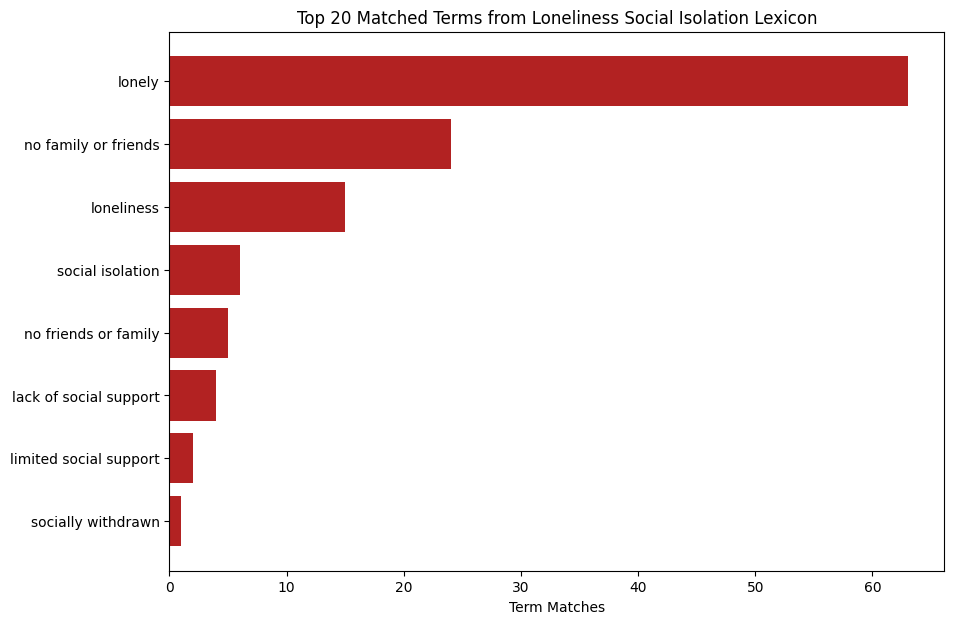

In [ ]:
import nltk
from nltk import bigrams, trigrams
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import string
import re

# Function to create count horizontal bar chat
def plot_most_common(n_most_common, title):
    items, counts = zip(*n_most_common)
    plt.figure(figsize=(10, 7))
    plt.barh(range(len(items)), counts, color='firebrick')
    plt.yticks(range(len(items)), items)
    plt.xlabel("Term Matches")  # Adding x-axis label
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.savefig(title + ".png", bbox_inches='tight', dpi=300)
    plt.show()

# Get the frequency of each matched term
matched_term_freq = Counter(quoted_dataframe2['matched_term'])

# Get top 20 most common matched terms
top20_matched_terms = matched_term_freq.most_common(20)

# Plot top 20 most common matched terms
plot_most_common(top20_matched_terms, 'Top 20 Matched Terms from Loneliness Social Isolation Lexicon')



# Expand using word embeddings

In [ ]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from collections import defaultdict
from gensim.models import Word2Vec, KeyedVectors

model = KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/Diss_Detecting_Provider_Bias/Aim 1/BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary = True)
# load in biowordvec model

In [ ]:
phrases_with_underscores = [phrase.replace(" ", "_") for phrase in phrases]

loneliness_words_df = pd.DataFrame({
    'stem_word': phrases_with_underscores
})

loneliness_words_df['most_similar_words'] = loneliness_words_df['stem_word'].apply(lambda x: model.most_similar(x, topn = 3) if x in model.key_to_index else None)

loneliness_words_df_2 = loneliness_words_df.explode("most_similar_words", ignore_index=True)
loneliness_words_df_2['new_word_id'] = range(1, 1 + len(loneliness_words_df_2))
# bias_words_df_2[['similar_word','similarity_score']] =
words_sep = pd.DataFrame(loneliness_words_df_2['most_similar_words'].values.tolist())
words_sep['new_word_id'] = range(1, 1 + len(loneliness_words_df_2))
loneliness_words_df_3 = loneliness_words_df_2.merge(words_sep, on = 'new_word_id')

loneliness_words_df_3= loneliness_words_df_3.rename(columns={0: "similar_word", 1: "score"})
loneliness_words_df_3["Relevant_to_study"] = ""
loneliness_words_df_3.to_csv("loneliness_lexicon_stem_and_similar_round1.csv")

loneliness_words_df_3 = pd.read_csv("loneliness_lexicon_stem_and_similar_round1.csv")
# Convert the "similar_word" column to string type
loneliness_words_df_3["similar_word"] = loneliness_words_df_3["similar_word"].astype(str)

# Function to extract the first word/phrase occurring between the first ( and the first comma
def extract_first_word(similar_word):
    if isinstance(similar_word, str):
        try:
            # Extract the substring inside the parentheses and before the first comma
            start = similar_word.find('(') + 1
            end = similar_word.find(',')
            if start != -1 and end != -1:
                word_part = similar_word[start:end].strip().split('/')[0].strip()
                word_part = word_part.strip('"').strip("'")
                print(f"Processing '{similar_word}' -> '{word_part}'")
                return word_part
            print(f"Failed to process '{similar_word}'")
            return None
        except Exception as e:
            print(f"Error processing {similar_word}: {e}")
            return None
    print(f"Not a string: {similar_word}")
    return None

# Apply the function to the "similar_word" column
loneliness_words_df_3["new_string"] = loneliness_words_df_3["similar_word"].apply(extract_first_word)

# Remove rows where "new_string" is None
loneliness_words_df_3 = loneliness_words_df_3.dropna(subset=["new_string"])

# Rename the "new_string" column to "similar_word"
loneliness_words_df_3 = loneliness_words_df_3.rename(columns={"new_string": "expanded_word"})

# Add a new column "expansion_source" with all values equal to "word2vec"
loneliness_words_df_3["expansion_source"] = "word2vec"


loneliness_words_word2vec = loneliness_words_df_3[["expanded_word", "expansion_source"]]

loneliness_words_word2vec

Failed to process 'nan'
Failed to process 'nan'
Failed to process 'nan'
Failed to process 'nan'
Failed to process 'nan'
Failed to process 'nan'
Failed to process 'nan'
Failed to process 'nan'
Failed to process 'nan'
Failed to process 'nan'
Failed to process 'nan'
Processing '('loneliness/boredom', 0.92421555519104)' -> 'loneliness'
Processing '('loneliness-a', 0.921669602394104)' -> 'loneliness-a'
Processing '('lonelinesstype', 0.9206938147544861)' -> 'lonelinesstype'
Processing '('not-lonely', 0.855924129486084)' -> 'not-lonely'
Processing '("'lonely", 0.8121781349182129)' -> 'lonely'
Processing '('nonlonely', 0.8105044960975647)' -> 'nonlonely'
Failed to process 'nan'
Failed to process 'nan'
Failed to process 'nan'
Failed to process 'nan'
Failed to process 'nan'
Failed to process 'nan'
Processing '("'friendlessness", 0.9512320756912231)' -> 'friendlessness'
Processing '('endlessness', 0.8929018378257751)' -> 'endlessness'
Processing '('boredom-mindlessness', 0.8917525410652161)' -> '

,expanded_word,expansion_source
11,loneliness,word2vec
12,loneliness-a,word2vec
13,lonelinesstype,word2vec
14,not-lonely,word2vec
15,lonely,word2vec
16,nonlonely,word2vec
23,friendlessness,word2vec
24,endlessness,word2vec
25,boredom-mindlessness,word2vec
30,ploner,word2vec


In [ ]:
!pip install openai
import openai
import os
from openai import OpenAI

OPENAI_API_KEY = pd.read_csv("/content/gdrive/MyDrive/Diss_Detecting_Provider_Bias/openai_api.csv", header=None).iloc[0, 0]
# Set the API key as an environment variable
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# Initialize the OpenAI client, it will automatically pick up the key from the environment
client = OpenAI()

In [ ]:
  import json


def generate_terms(new_loneliness_phrases):
    """Generate a new list of 50 additional words or phrases,  which may be used to describe patients who are lonely or socially isolated, typically written in medical charts."""
    loneliness_phrases = {
        "new_loneliness_phrases": ','.join(phrases),
    }
    return json.dumps(loneliness_phrases)


    # Step 1: send the conversation and available functions to GPT
messages = [{"role": "system", "content": "Imagine that you are an expert in studying social isolation expressed within electronic health records. Do not use words previously developed in a list appended to the next sentence. Here is a previously-developed list of social isolation or loneliness words and phrases:\n\n" + "\n\n".join(phrases)},
        {"role": "user", "content": "Generate a new list of 50 additional unique words or phrases, which may be used to identify lonely or isolated patients, typically written in medical charts."}]
functions = [
        {
            "name": "generate_terms",
            "description": "Generate a new list of 50 additional words or phrases, which may be used to identify lonely or isolated patients, typically written in medical charts.",
            "parameters": {
                "type": "object",
                "properties": {
                    "new_loneliness_phrases": {
                        "type": "string",
                        "description": "A new list of 50 additional words which may be used to identify lonely or isolated patients in electronic health records",
                    },
                },
                "required": ["new_loneliness_phrases"],
            },
        }
    ]
completion = client.chat.completions.create(
      model="gpt-3.5-turbo-0125",
      messages=messages,
      functions=functions,
      function_call="auto",  # auto is default, but we'll be explicit
    )

args = json.loads(completion.choices[0].message.function_call.arguments)
print(args)



# Split the string value associated with the key 'new_loneliness_phrases' into a list
new_loneliness_phrases = args['new_loneliness_phrases'].split('\n')

# Convert the list to a DataFrame
df = pd.DataFrame(new_loneliness_phrases, columns=['phrase'])

# Save the DataFrame to a .csv file
df.to_csv('new_loneliness_phrases.csv', index=False)



# read in Chat GPT 3.5 words, combine with original phrases

In [ ]:
# original phrases
phrases_df = pd.DataFrame(phrases, columns = ["expanded_word"])
phrases_df["expansion_source"] = "Zhu_Article"
phrases_df

chat_gpt_phrases = pd.read_csv("new_loneliness_phrases.csv")
chat_gpt_phrases = chat_gpt_phrases.rename(columns={"phrase": "expanded_word"})
chat_gpt_phrases['expansion_source'] = "chat_gpt"
chat_gpt_phrases = chat_gpt_phrases[["expanded_word", "expansion_source"]]
chat_gpt_phrases

combined_df = pd.concat([phrases_df,loneliness_words_word2vec, chat_gpt_phrases], ignore_index=True)
combined_df['refers_to_loneliness_social_isolation'] = ""
combined_df = combined_df.drop_duplicates(subset='expanded_word')
combined_df
combined_df.index.name = 'word_id'

combined_df.to_csv("loneliness_social_isolation_lexicon_evaluation.csv", index=True)

In [ ]:
def extract_phrases(data, key):
    if key in data:
        return data[key].split('\n')
    else:
        return []

# Extract the list
new_loneliness_phrases = extract_phrases(args, 'new_loneliness_phrases')

# Display the list
print(new_loneliness_phrases)


['solitary', 'alone', 'secluded', 'unaccompanied', 'emotional detachment', 'abandoned', 'unconnected', 'unattended', 'isolated lifestyle', 'deserted', 'uninvolved', 'withdrawn', 'stranded', 'remote', 'alone in the world', 'isolated living', 'unsociable', 'estranged', 'outsider', 'unwanted', 'shunned', 'lack of companionship', 'alone time', 'hermit', 'isolated existence', 'isolated behavior', 'socially excluded', 'aloof', 'hermitic', 'lack of interaction', 'rejected by society', 'social detachment', 'detached from others', 'independent living', 'excluded', 'reclusive', 'lack of belonging', 'separation from others', 'unattached', 'solitude', 'individualistic', 'unaccompanied lifestyle', 'withdrawn behavior']


# Second expanded search

In [ ]:
new_loneliness_phrases = pd.read_csv("new_loneliness_phrases.csv")
new_loneliness_phrases = new_loneliness_phrases['phrase'].tolist()
new_loneliness_phrases

['solitary',
 'alone',
 'secluded',
 'rejected',
 'unaccompanied',
 'emotional detachment',
 'abandoned',
 'unconnected',
 'unattended',
 'isolated lifestyle',
 'deserted',
 'disconnected',
 'uninvolved',
 'withdrawn',
 'stranded',
 'remote',
 'alone in the world',
 'isolated living',
 'unsociable',
 'estranged',
 'outsider',
 'unwanted',
 'shunned',
 'lack of companionship',
 'alone time',
 'hermit',
 'isolated existence',
 'isolated behavior',
 'socially excluded',
 'aloof',
 'hermitic',
 'lack of interaction',
 'rejected by society',
 'social detachment',
 'detached from others',
 'independent living',
 'hidden',
 'excluded',
 'reclusive',
 'lack of belonging',
 'separation from others',
 'apart',
 'unattached',
 'solitude',
 'individualistic',
 'unaccompanied lifestyle',
 'withdrawn behavior',
 'antagonistic']

In [ ]:
# Remove possible noisy medical terms
words_to_remove = {'disconnected', 'rejected','antagonistic','apart','hidden','withdrawn','remote','excluded','unattached','unwanted','uninvolved','unattended','abandoned','unconnected','solitary', 'alone'}
new_loneliness_phrases = [word for word in new_loneliness_phrases if word not in words_to_remove]

phrases_2 = phrases + new_loneliness_phrases

# Join phrases with '|' and create a regex pattern
pattern = '|'.join([re.escape(phrase) for phrase in phrases_2])
regex = re.compile(pattern, re.IGNORECASE)

def identify_matching_strings(full_dataframe, phrases):
    matching_dataframes = []

    for phrase in phrases:
        term = r"\b" + re.escape(phrase) + r"\b"  # Adding word boundaries
        matches = full_dataframe.loc[full_dataframe['Sentence'].str.contains(term, flags=re.IGNORECASE, na=False)].copy()
        matches['regex'] = pattern
        matches['matched_term'] = phrase  # Add the matched term as a new column
        matching_dataframes.append(matches)

    first_dataframe = pd.concat(matching_dataframes, ignore_index=True)
    return first_dataframe

# Replace with full dataframe
quoted_dataframe_3 = identify_matching_strings(full_dataframe, phrases_2)


# adding annotator variables
quoted_dataframe_3
quoted_dataframe_3["loneliness"] = ""
quoted_dataframe_3["annotator_comments"] = ""
# removing duplicate sentences
quoted_dataframe4 = quoted_dataframe_3.drop_duplicates(subset=['Sentence'])
print(f"Sentences of loneliness matches: {quoted_dataframe4.shape[0]}")  # Print the size after filter
quoted_dataframe4.head()

unique_subject_ids_count2 = quoted_dataframe4['SUBJECT_ID'].nunique()

print(f"Number of unique patients: {unique_subject_ids_count2}")

# writing to excel file
quoted_dataframe4.to_excel("loneliness_matches_expanded.xlsx", index = False)

Sentences of loneliness matches: 2628
Number of unique patients: 1433


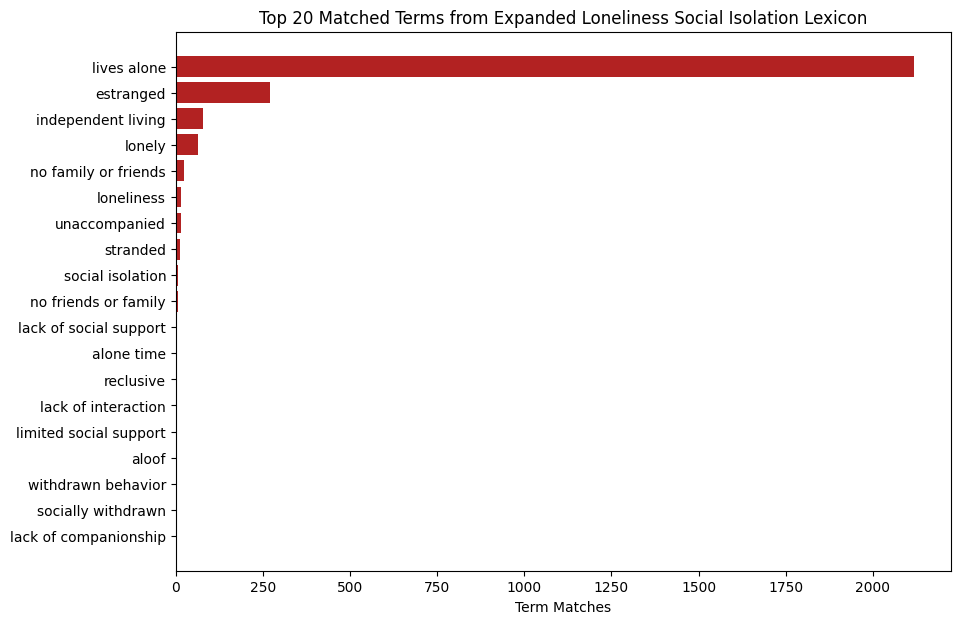

In [ ]:
import nltk
from nltk import bigrams, trigrams
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import string
import re

# Function to create count horizontal bar chat
def plot_most_common(n_most_common, title):
    items, counts = zip(*n_most_common)
    plt.figure(figsize=(10, 7))
    plt.barh(range(len(items)), counts, color='firebrick')
    plt.yticks(range(len(items)), items)
    plt.xlabel("Term Matches")  # Adding x-axis label
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.savefig(title + ".png", bbox_inches='tight', dpi=300)
    plt.show()

# Get the frequency of each matched term
matched_term_freq_2 = Counter(quoted_dataframe4['matched_term'])

# Get top 20 most common matched terms
top20_matched_terms_2 = matched_term_freq_2.most_common(20)

# Plot top 20 most common matched terms
plot_most_common(top20_matched_terms_2, 'Top 20 Matched Terms from Expanded Loneliness Social Isolation Lexicon')
